# Earthquake data preprocessing

The goal of this competition is to use seismic signals to predict the timing of laboratory earthquakes. The data comes from a well-known experimental set-up used to study earthquake physics. The `acoustic_data` input signal is used to predict the time remaining before the next laboratory earthquake (`time_to_failure`).

The training data is a single, continuous segment of experimental data. The test data consists of a folder containing many small segments. The data *within* each test file is continuous, but the test files do not represent a continuous segment of the experiment; thus, the predictions cannot be assumed to follow the same regular pattern seen in the training file.

For each `seg_id` in the test folder, you should predict a *single* `time_to_failure` corresponding to the time between the *last row of the segment* and the next laboratory earthquake.

# Links

Data description: https://www.kaggle.com/c/LANL-Earthquake-Prediction/data

Additional info: https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526

In [18]:
import os, sys
import os.path as osp
import pandas as pd
import numpy as np
from glob import glob
import tqdm
import shutil
import time

from multiprocessing import Process, Queue
import tensorflow as tf  # for writing TFRecords

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir('/workspace/persistent-data/earthquake/')

In [3]:
def timestamp():
    return time.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
QUAKES = 'train/train.csv'

In [5]:
# quakes = pd.read_csv(QUAKES, header=0, names=['acoustic_data', 'time_to_failure'],
#                      dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
#                      engine='c', compression=None, low_memory=False)

In [6]:
# # Save to pickle for faster reading later
# quakes.to_pickle('train/train.pickle')

In [7]:
quakes = pd.read_pickle('train/train.pickle')

In [6]:
quakes.shape

(629145480, 2)

In [7]:
quakes.head(3)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691


In [8]:
quakes.dtypes

acoustic_data        int16
time_to_failure    float64
dtype: object

# Feature histograms

In [8]:
def hist(data, title=None, bins=100):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.hist(data, bins=100)
    if title is None:
        try:
            title = data.name
        except:
            title = 'histogram generated at %s' % timestamp()
    ax.set_title(title)
    plt.show()

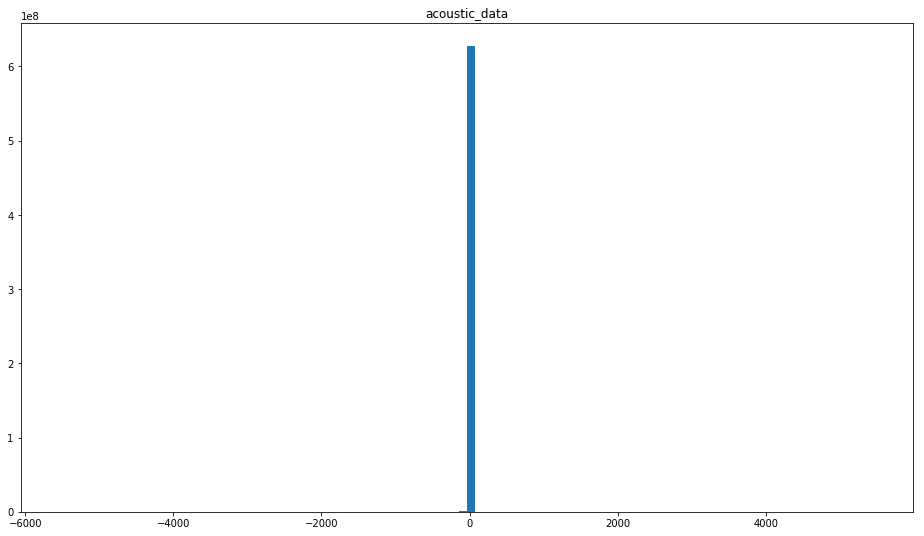

In [24]:
hist(quakes['acoustic_data'])

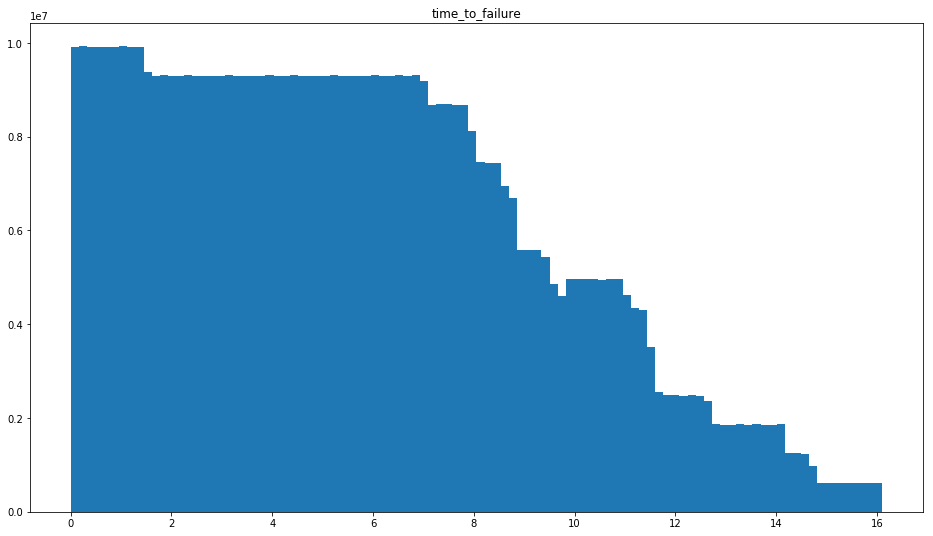

In [25]:
hist(quakes['time_to_failure'])

# Feature plots over time

In [16]:
def line_plot(x, y, title=None, linewidth=0.5, reversex=False):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(x, y, linewidth=linewidth)
    if title is None:
        try:
            title = x.name + ' vs. ' + y.name
        except:
            title = 'line_plot generated at %s' % timestamp()
    ax.set_title(title)
    if reversex:
        xlim = ax.get_xlim()
        ax.set_xlim(xlim[1], xlim[0])
    plt.show()

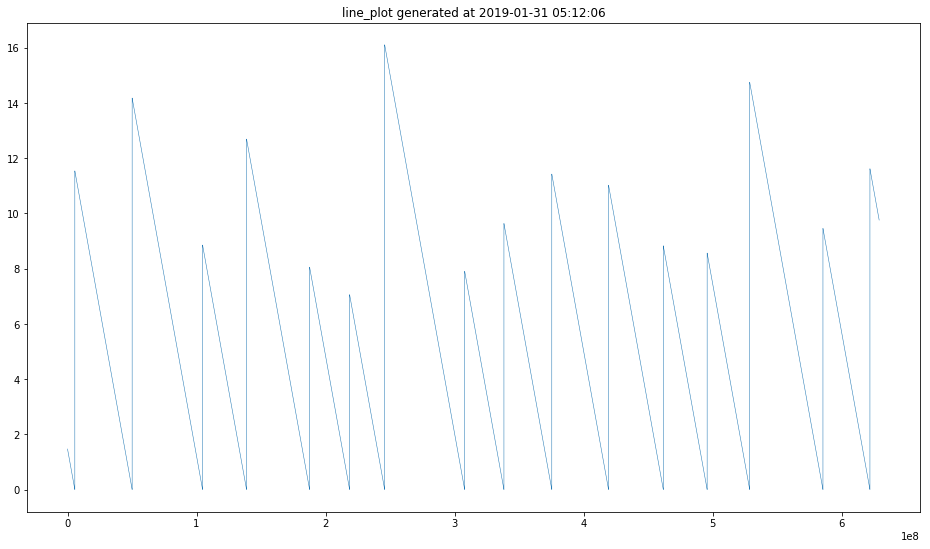

In [29]:
line_plot(range(len(quakes)), quakes['time_to_failure'])

In [12]:
quake_indexes = np.where(quakes['time_to_failure'].diff() > 0)[0]

In [13]:
quake_indexes = list(zip([0] + quake_indexes.tolist(), quake_indexes.tolist() + [len(quakes)]))

In [14]:
print('\n'.join(map(lambda x: 'Earthquake %d:\t%s' % (x[0] + 1, x[1]), enumerate(quake_indexes))))

Earthquake 1:	(0, 5656574)
Earthquake 2:	(5656574, 50085878)
Earthquake 3:	(50085878, 104677356)
Earthquake 4:	(104677356, 138772453)
Earthquake 5:	(138772453, 187641820)
Earthquake 6:	(187641820, 218652630)
Earthquake 7:	(218652630, 245829585)
Earthquake 8:	(245829585, 307838917)
Earthquake 9:	(307838917, 338276287)
Earthquake 10:	(338276287, 375377848)
Earthquake 11:	(375377848, 419368880)
Earthquake 12:	(419368880, 461811623)
Earthquake 13:	(461811623, 495800225)
Earthquake 14:	(495800225, 528777115)
Earthquake 15:	(528777115, 585568144)
Earthquake 16:	(585568144, 621985673)
Earthquake 17:	(621985673, 629145480)


# Plot acoustic activity over time for each earthquake separately

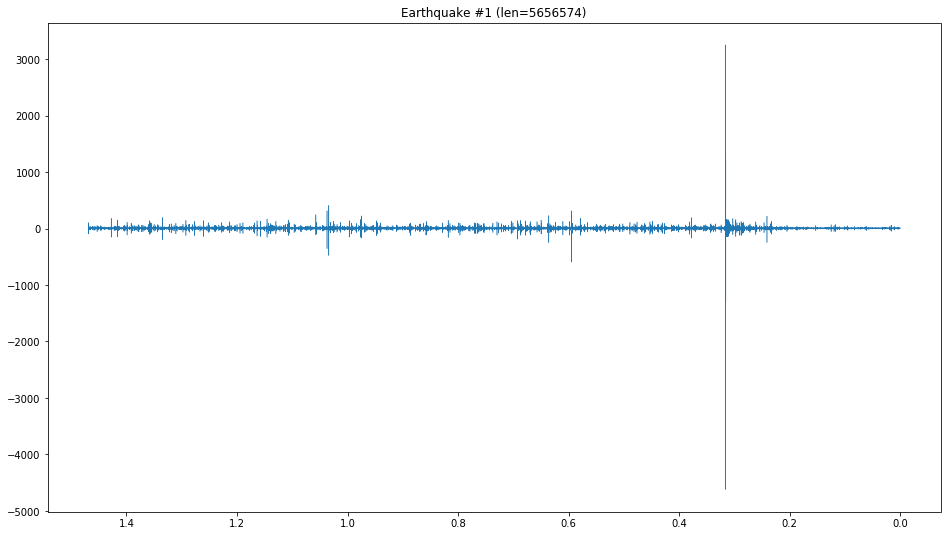

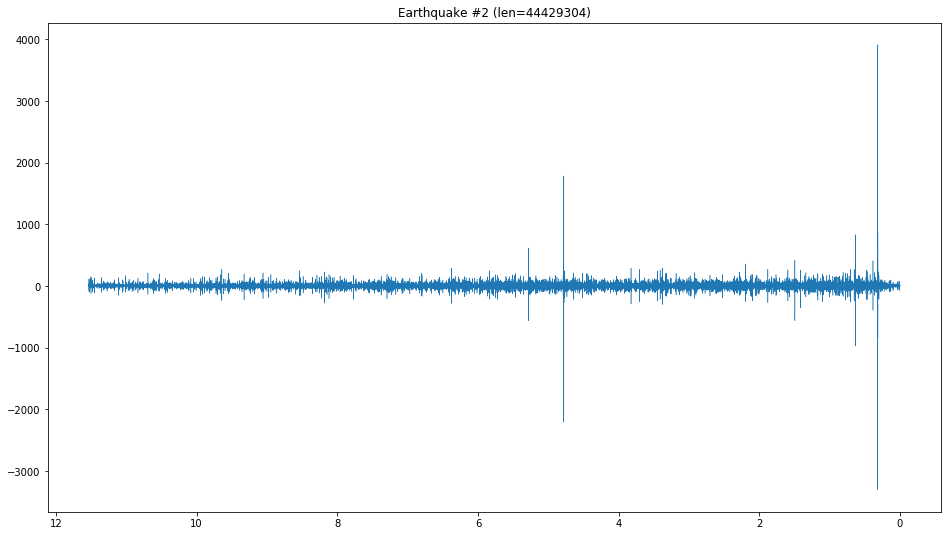

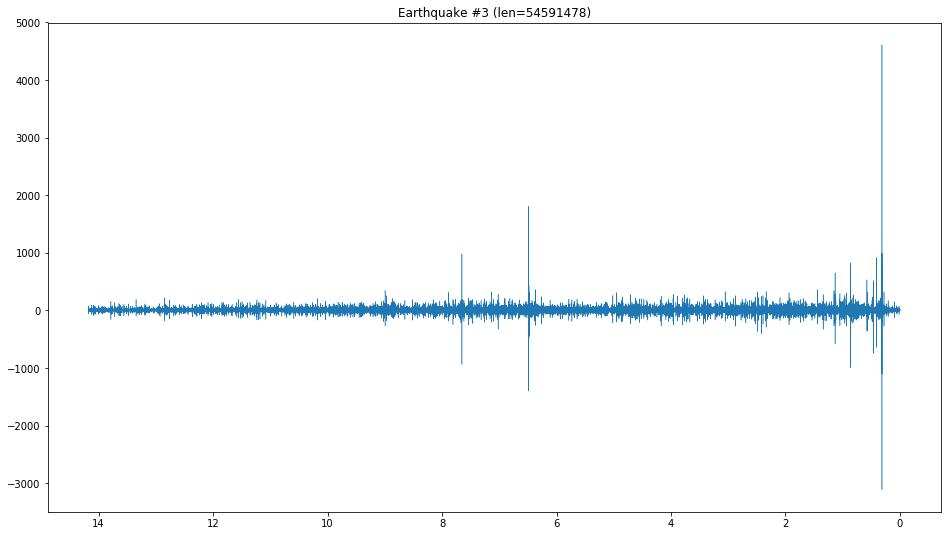

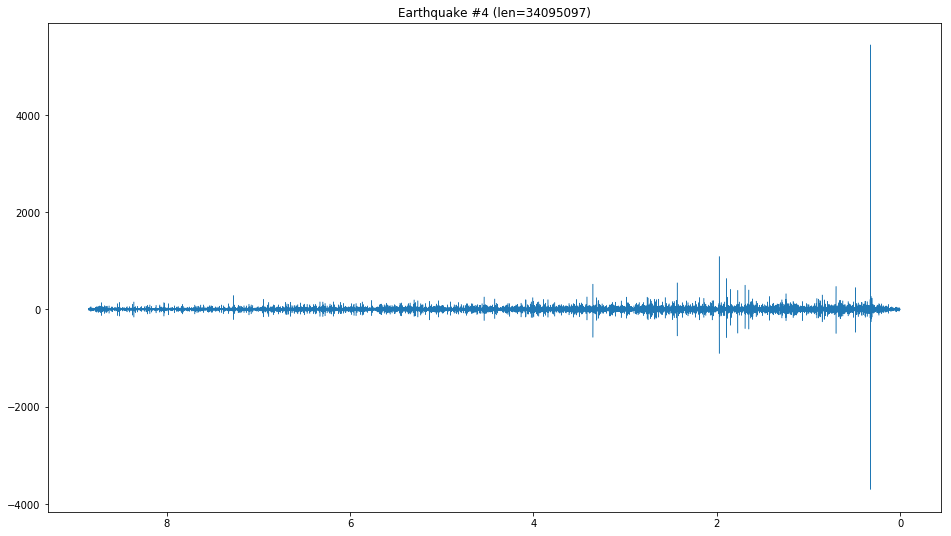

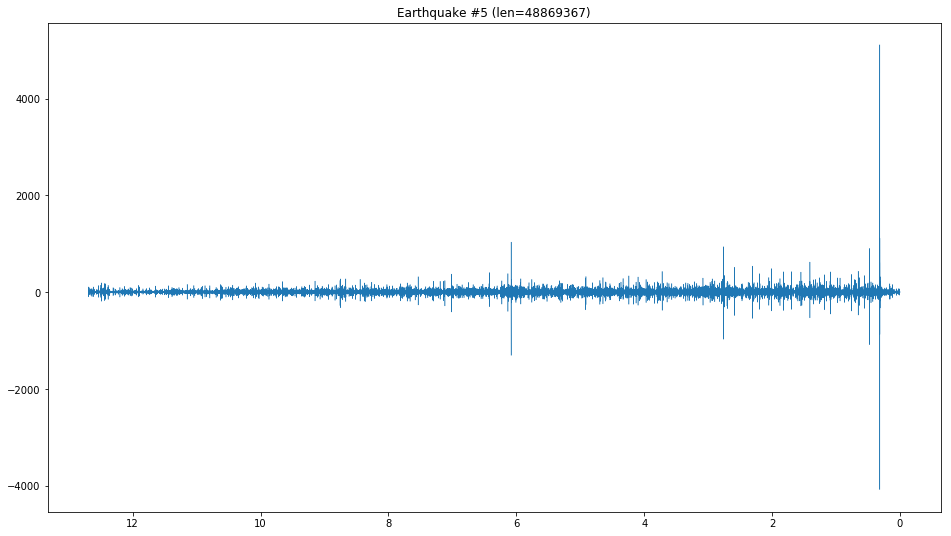

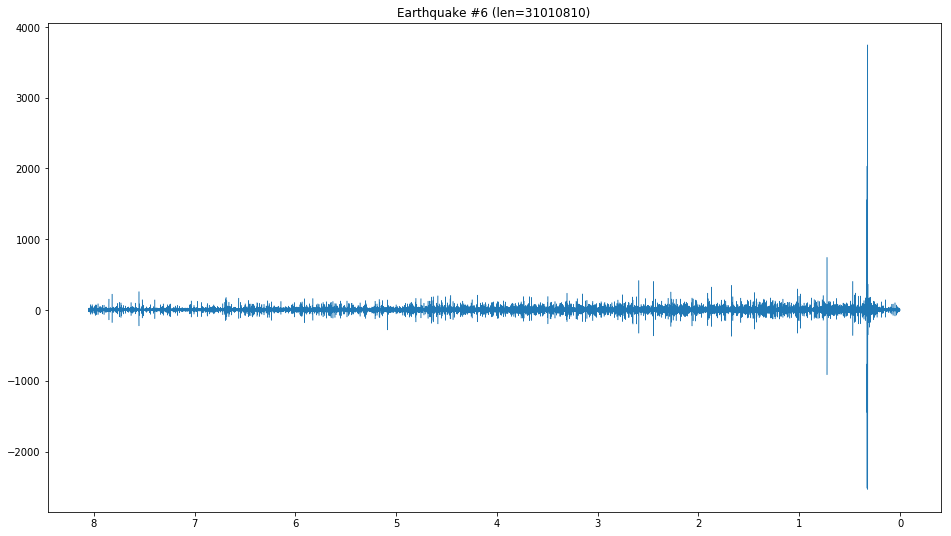

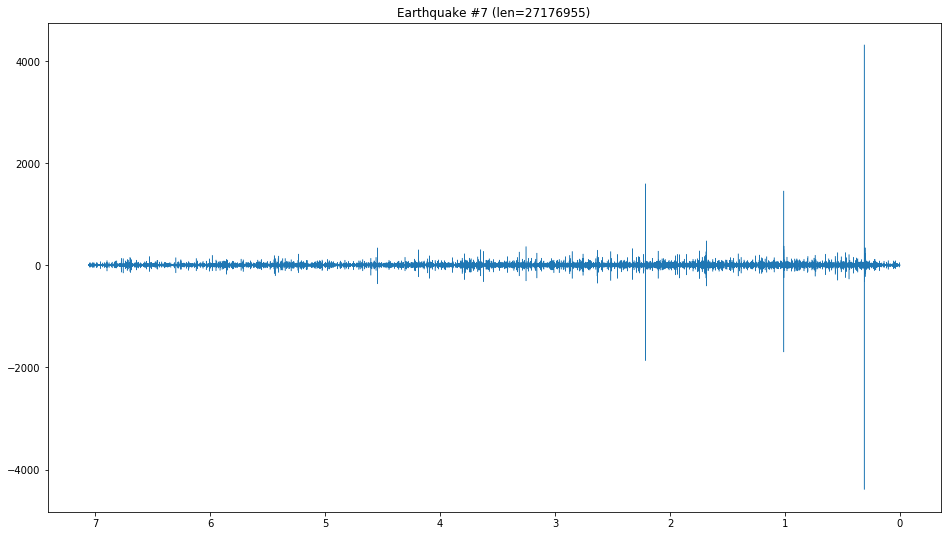

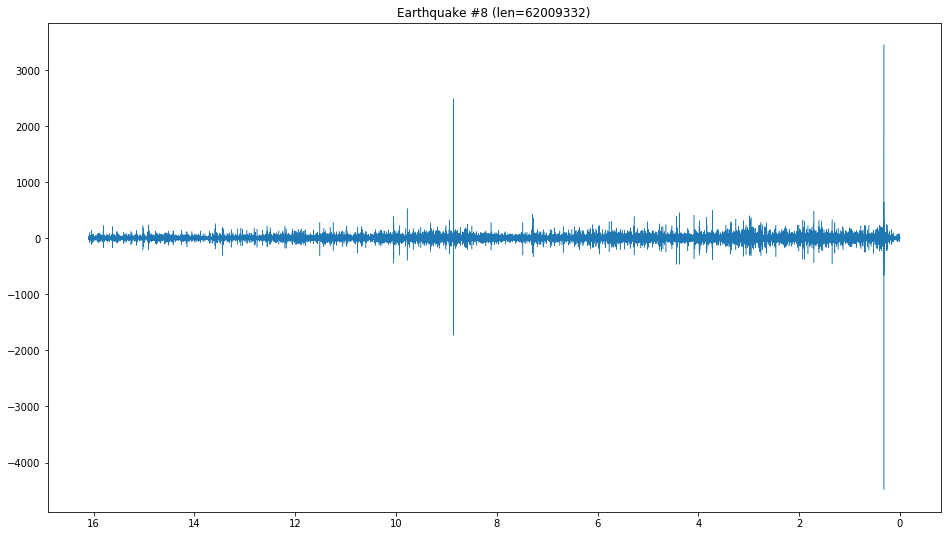

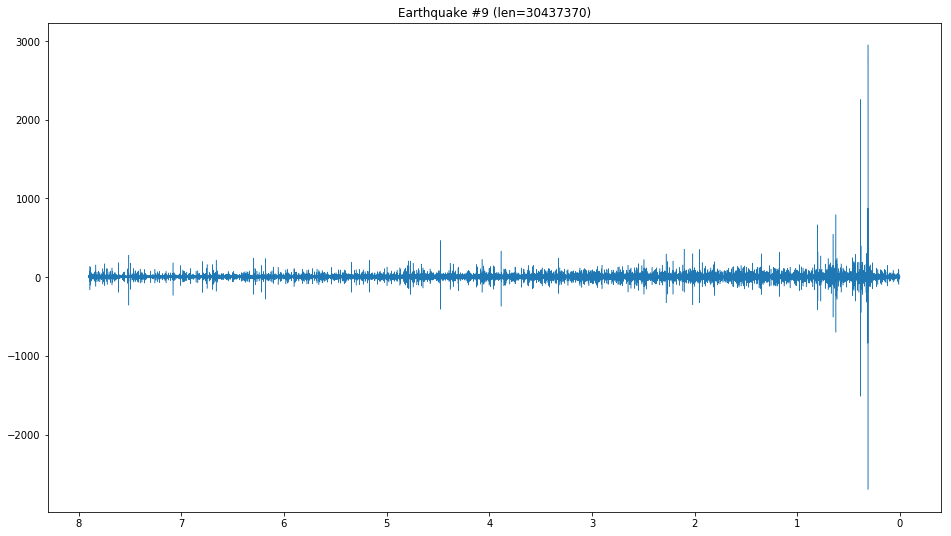

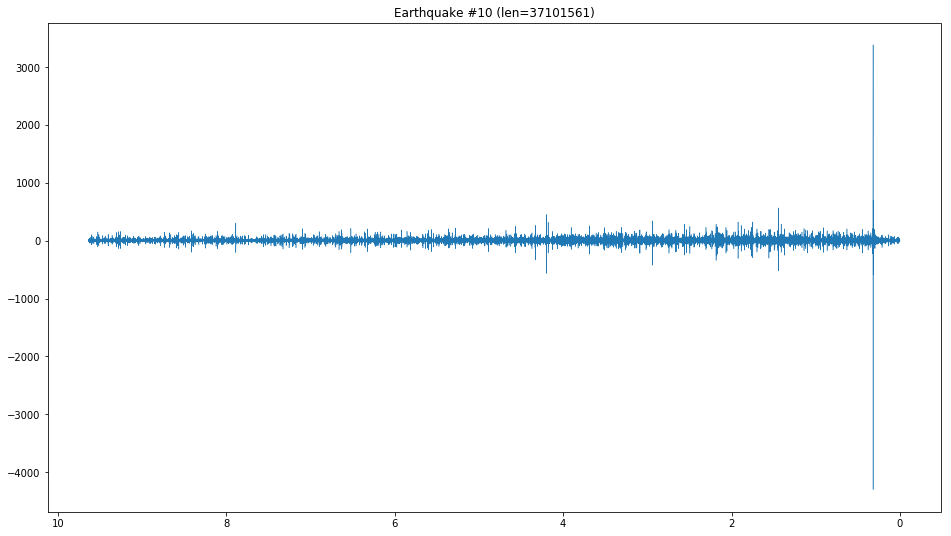

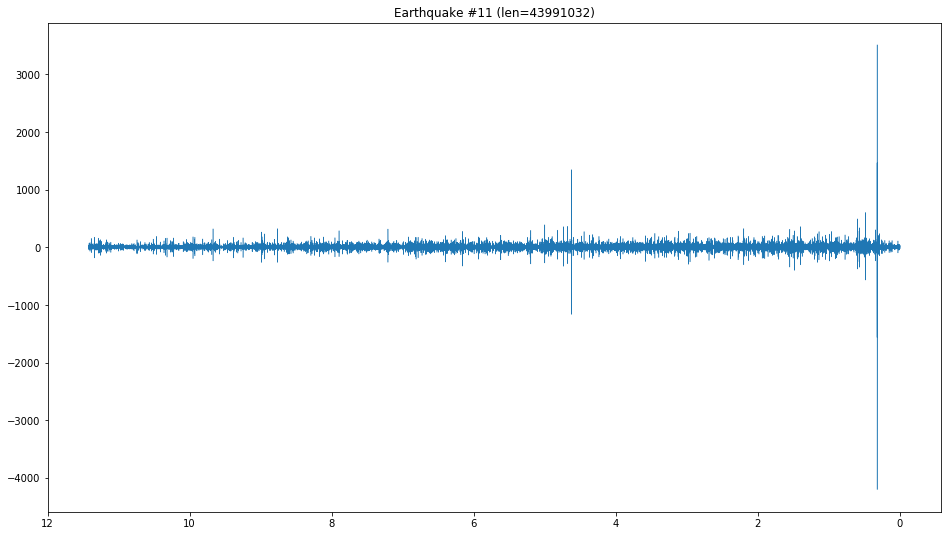

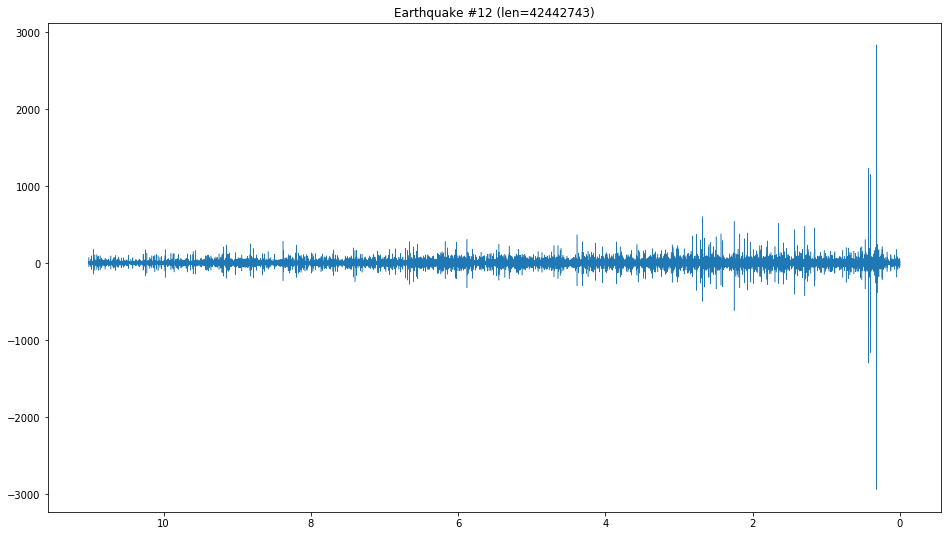

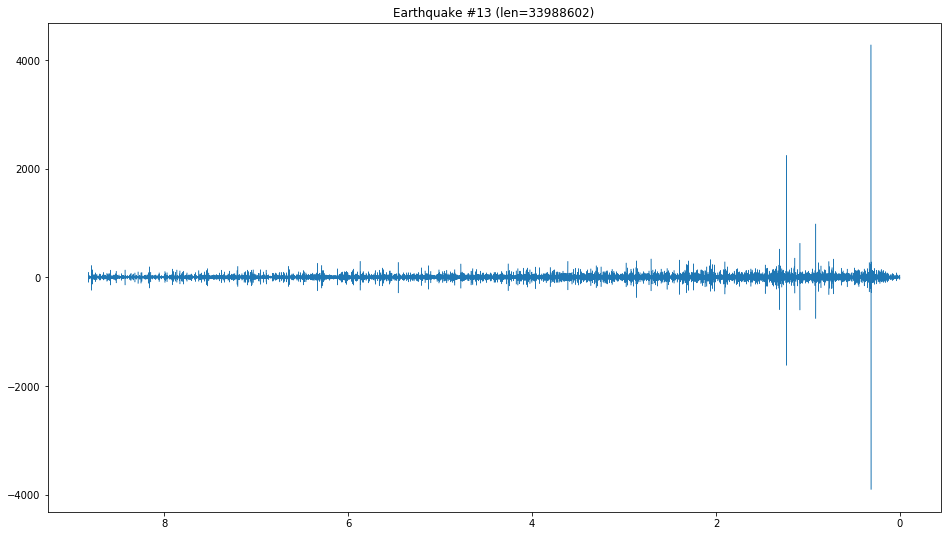

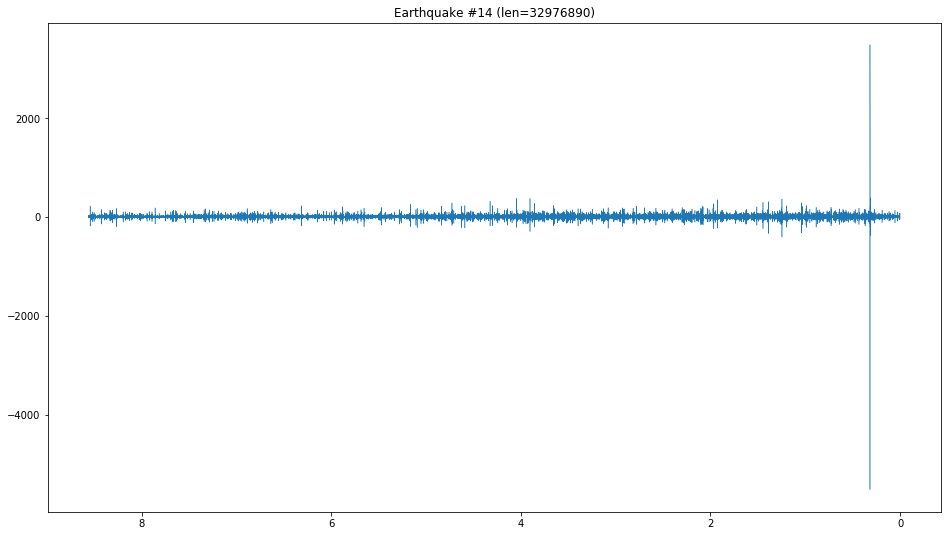

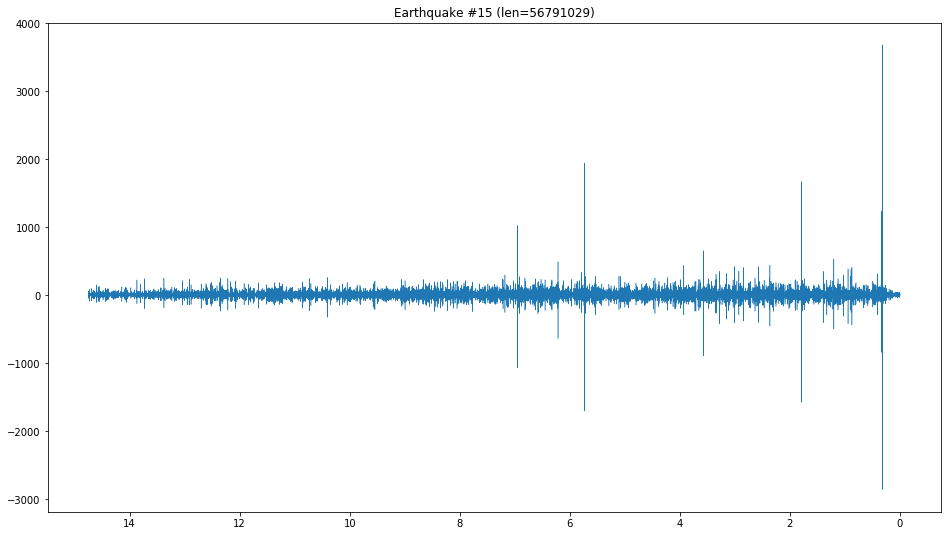

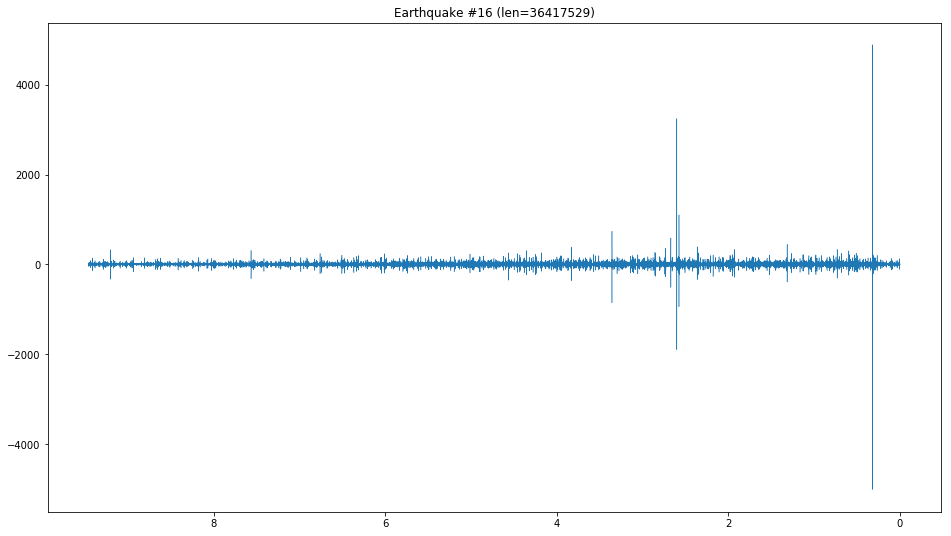

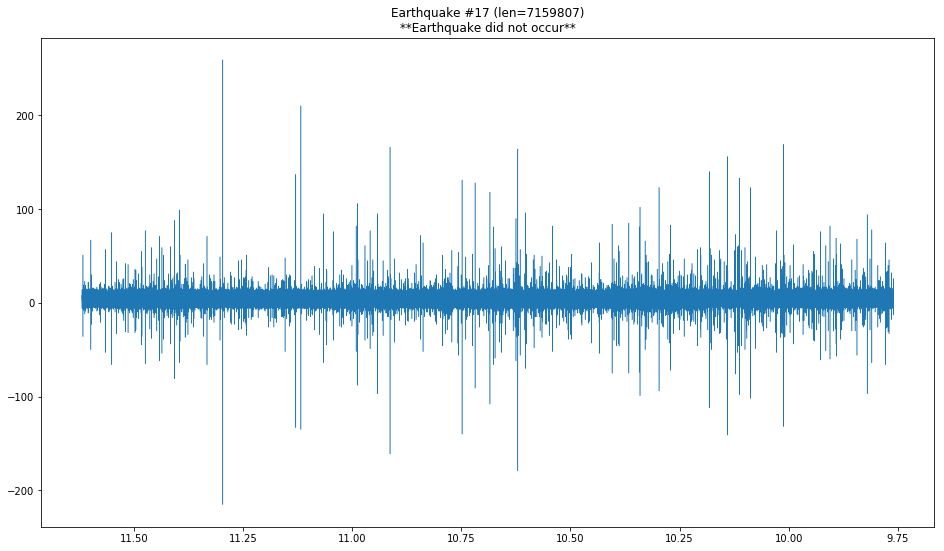

In [17]:
for quake_num, quake_start_end in enumerate(quake_indexes):
    quake_start = quake_start_end[0]
    quake_end = quake_start_end[1]
    quake_len = quake_end - quake_start
    title = 'Earthquake #%d (len=%d)' % (quake_num + 1, quake_end - quake_start)
    if quake_num == len(quake_indexes) - 1:
        title += '\n**Earthquake did not occur**'
    line_plot(quakes['time_to_failure'].iloc[quake_start:quake_end],
              quakes['acoustic_data'].iloc[quake_start:quake_end],
              title=title,
              reversex=True)

# To pickle, then to TFRecord

#### First, to pickle

In [5]:
PICKLE_DIR = '/workspace/persistent-data/earthquake/pickles'

In [11]:
!mkdir -p {PICKLE_DIR}

In [16]:
for quake_num, quake_start_stop in tqdm.tqdm(enumerate(quake_indexes), total=len(quake_indexes), ascii=True):
    quake_start = quake_start_stop[0]
    quake_end = quake_start_stop[1]
    quake_len = quake_end - quake_start
    out_pickle_fn = osp.join(PICKLE_DIR, '%d-%d.pickle' % (quake_num+1, quake_len))
    subdf = quakes.iloc[quake_start:quake_end]
    subdf.to_pickle(out_pickle_fn)

100%|##########| 17/17 [00:08<00:00,  1.95it/s]


#### Now, to TFRecord

In [6]:
TFRECORD_DIR = '/workspace/persistent-data/earthquake/tfrecords3'

In [7]:
!rm -rf {TFRECORD_DIR} && mkdir -p {TFRECORD_DIR}

In [8]:
## TFRecord helper functions

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

# The following functions come from the TFRecords example [https://www.tensorflow.org/tutorials/load_data/tf-records]
# and a Float64 hack from https://github.com/tensorflow/tensorflow/issues/12876

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _float64_feature(value):
    """Returns a bytes_list of encoded float64"""
    value = [str(x).encode() for x in value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_example(acoustic_data, tminus):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    
    feature = {
        'acousticdata': _int64_feature(acoustic_data),
        'tminus': _float64_feature(tminus)
    }
    
    # Create a Features message using tf.train.Example.
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [9]:
def pickle_to_tfrecords(pick):
    RECS_PER_TFRECORD = 1500000
    
    df = pd.read_pickle(pick)
    slug = osp.split(pick)[1].split('.')[0]
    
    N = 0
    l = len(df)
    while N < l:
        next_N = N + RECS_PER_TFRECORD
        
        if next_N >= l:
            # we would have overflowed, write final segment (yes, we duplicate some overlap... oh well.)
            N = l - RECS_PER_TFRECORD
            next_N = l
        
        assert next_N - N == RECS_PER_TFRECORD
        subdf = df.iloc[N:next_N]
        serex = serialize_example(subdf['acoustic_data'].values, subdf['time_to_failure'].values)
        
        outfn = osp.join(TFRECORD_DIR, '%s-%d.tfrecord' % (slug, N))
        with tf.python_io.TFRecordWriter(outfn) as writer:
            writer.write(serex)
            
        N = next_N

In [10]:
pickles = glob(osp.join(PICKLE_DIR, '*.pickle'))
print(len(pickles))

17


In [11]:
def split_work_helper(q, do):
    while True:
        try:
            elem = q.get(timeout=0.5)
        except:
            break
        do(elem)

In [12]:
q = Queue(len(pickles))
for p in pickles:
    q.put(p)
processes = [Process(name=i, target=split_work_helper, args=(q, pickle_to_tfrecords)) for i in range(4)]

In [13]:
print('[%s] qsize=%d' % (timestamp(), q.qsize()))

for p in processes:
    p.start()

while True:
    sz = q.qsize()
    if sz == 0:
        break
    print('[%s] qsize=%d' % (timestamp(), sz))
    time.sleep(10)

for p in processes:
    p.join()
    p.terminate()

print('[%s] operation completed successfully' % timestamp())

[2019-01-31 07:46:11] qsize=17
[2019-01-31 07:46:11] qsize=14
[2019-01-31 07:46:21] qsize=13
[2019-01-31 07:46:31] qsize=12
[2019-01-31 07:46:41] qsize=12
[2019-01-31 07:46:51] qsize=12
[2019-01-31 07:47:01] qsize=12
[2019-01-31 07:47:11] qsize=12
[2019-01-31 07:47:21] qsize=11
[2019-01-31 07:47:31] qsize=11
[2019-01-31 07:47:41] qsize=10
[2019-01-31 07:47:51] qsize=10
[2019-01-31 07:48:01] qsize=10
[2019-01-31 07:48:11] qsize=8
[2019-01-31 07:48:21] qsize=8
[2019-01-31 07:48:31] qsize=7
[2019-01-31 07:48:41] qsize=6
[2019-01-31 07:48:51] qsize=6
[2019-01-31 07:49:01] qsize=6
[2019-01-31 07:49:11] qsize=5
[2019-01-31 07:49:21] qsize=5
[2019-01-31 07:49:31] qsize=5
[2019-01-31 07:49:41] qsize=4
[2019-01-31 07:49:51] qsize=4
[2019-01-31 07:50:01] qsize=4
[2019-01-31 07:50:11] qsize=2
[2019-01-31 07:50:21] qsize=2
[2019-01-31 07:50:31] qsize=1
[2019-01-31 07:50:41] qsize=1
[2019-01-31 07:52:03] operation completed successfully


## Val-*ish*-dation: compare pickle and TFrecord file sizes

In [14]:
!du -ks {PICKLE_DIR}
!du -ks {TFRECORD_DIR}

6144072	/workspace/persistent-data/earthquake/pickles
10869492	/workspace/persistent-data/earthquake/tfrecords3


# Move some files over for the test set

In [15]:
!mkdir -p {TFRECORD_DIR}/train
!mkdir -p {TFRECORD_DIR}/test

In [22]:
tfrecs = glob(osp.join(TFRECORD_DIR, '*.tfrecord'))

In [23]:
np.random.shuffle(tfrecs)

In [25]:
TEST_PCT = 0.1

In [26]:
N_test = int(TEST_PCT * len(tfrecs))

In [27]:
for f in tfrecs[:N_test]:
    shutil.move(f, osp.join(TFRECORD_DIR, 'test'))

In [28]:
for f in tfrecs[N_test:]:
    shutil.move(f, osp.join(TFRECORD_DIR, 'train'))